In [1]:
pip install uproot 

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install vector 

Note: you may need to restart the kernel to use updated packages.


In [3]:
import uproot 
import vector 
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import awkward as ak 

In [14]:
def data_extract(rootfilename):

    # Opens the .root file and extract the data

    tree = uproot.open(rootfilename+'.root:Delphes')

    events = tree.arrays(['Event.Weight','Electron_size', 'Electron.PT', 'Electron.Eta', 'Electron.Phi',
                              'Muon_size', 'Muon.PT', 'Muon.Eta', 'Muon.Phi',
                          'Jet_size', 'Jet.PT', 'Jet.Eta', 'Jet.Phi', 'Jet.TauTag', 'Jet.Mass', 'Jet.Flavor', 'Jet.BTag', 
                         'MissingET.MET', 'MissingET.Eta', 'MissingET.Phi'])

    return events

def jet_and_lepton(event, selection, lepton):
    #Selects events with two electrons and at least two jets, that can change the jet filters selection = 0 filter 
    #for no b jets and 2 or 3 light, 
    # selection = 1 is no be jets, selection = 2 doesnt mask based on b tagging 
    
    #creates four vectors of all detected particles in all events
    electrons = vector.zip({'pt': (event['Electron.PT']), 'eta': (event['Electron.Eta']),
                            'phi': (event['Electron.Phi']), 'mass': 0.0511})
    
    jets = vector.zip({'pt': (event['Jet.PT']), 'eta': (event['Jet.Eta']),
                       'phi': (event['Jet.Phi']), 'mass': (event['Jet.Mass'])})
    
    missing = vector.zip({'pt': (event['MissingET.MET']), 'eta': (event['MissingET.Eta']),
                            'phi': (event['MissingET.Phi']), 'mass': 0})
    
    muons = vector.zip({'pt': (event['Muon.PT']), 'eta': (event['Muon.Eta']),
                            'phi': (event['Muon.Phi']), 'mass': 0.10566})
    
    #start creating the event mask which determines whether to cut EVENT or not
    no_e_mask = event['Electron_size'] == 0
    
    mu_mask = event['Muon_size'] == 1

    
    pt_above_25 = event['Jet.PT'] >= 25
    one_jet_above_25_mask = ak.num(pt_above_25, axis=1) == 1
    #requires that we only consider events with at least 2 non tau jets above 25GeV, anything below we dont consider as jets.
    
    b_tag = event['Jet.BTag'] == 1
    filtered_data_b = jets[b_tag]
    no_b_jet_mask = ak.num(filtered_data_b, axis=1) == 0 
    
    light_jets = event['Jet.BTag'] == 0
    filtered_data_light = jets[light_jets]
    n_light_jet_min_mask = ak.num(filtered_data_light, axis=1) > 0 
    n_light_jet_max_mask = ak.num(filtered_data_light, axis=1) < 2
    n_light_jet_mask = n_light_jet_min_mask & n_light_jet_max_mask
    
    
    #finished creating event mask now we can interactively change which masks are zipped into overall event mask 
    if selection == 0:
        event_mask = one_jet_above_25_mask & no_b_jet_mask & n_light_jet_mask
    elif selection == 1:
        event_mask = one_jet_above_25_mask & no_b_jet_mask
    elif selection == 2:
        event_mask = one_jet_above_25_mask
       
    
    #interactively determine whether we want to return muons or electrons
    if lepton == 'electron':
        event_mask = event_mask & e_mask & no_mu_mask
    elif lepton == 'muon':
        event_mask = event_mask & no_e_mask & mu_mask

    # now filter the 4 vectors with the masks made
    jet_electron = electrons[event_mask]
    jet_muon = muons[event_mask]
    missing_momentum = missing[event_mask]
    
    #event filtered jets 
    jets_filtered = jets[event_mask]
    
    #leading jets found at 0 and 1 and guaranteed to be at PT above 25 due to event mask 
    leading_jet = jets_filtered[:,0]

   

    
    
    #return different sets dependig on if you want electron or muon
    
    if lepton == 'electron':
        return jet_electron[:,0], leading_jet, missing_momentum
    elif lepton == 'muon':
        return jet_muon[:,0], leading_jet, missing_momentum
    
def scatter_plot_muon_MET(muon, lead):
    plt.scatter(muon.pt, lead.pt, s=0.5, color='red')
    plt.ylabel('Magnitude of Missing ET [GeV]')
    plt.xlabel('Jet PT [GeV]')
    plt.title('Scatter plot of Missing ET against Jet PT')
    plt.savefig('scatter_plot_muon_vs_MET.png')

[{rho: 43.2, phi: 1.23, eta: -1.45, tau: 0.106}, {...}, ..., {rho: 31.1, ...}]
[{rho: 43, phi: -1.91, eta: -0.507, tau: 0.116}, {...}, ..., {rho: 40.9, ...}]
[[{rho: 11.7, phi: 2.02, eta: -3.78, tau: 0}], [{...}], ..., [{rho: 8.74, ...}]]


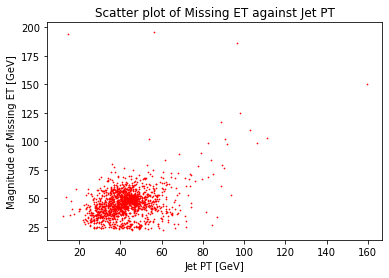

In [15]:
muon, lead, miss = jet_and_lepton(data_extract('mumu_production'), 0, 'muon')
print(muon)
print(lead)
print(miss)
scatter_plot_muon_MET(muon, lead)